In [5]:
# Read in all the words
# words = open('words.txt', 'r').read().splitlines()
words = open('words.txt', 'r').read().split()

# Let's see what we have
# print(f"Number of words: {len(words)}")
# print(f"First 10 words: {words[:10]}")


Number of words: 436
First 10 words: ['Aabha', 'Aabharana', 'Aadi', 'Aadidev', 'Aaditya', 'Aagam', 'Aagneya', 'Agasti', 'Aashwith', 'Aamod']


In [9]:
import torch
import string
import re

# Normalize words: lowercase, only keep a-z
words = [re.sub(r'[^a-z]', '', w.lower()) for w in words if re.sub(r'[^a-z]', '', w.lower())]

# Define full alphabet plus the special token
alphabet = list(string.ascii_lowercase)
s2i = {ch: i+1 for i, ch in enumerate(alphabet)}  # indices 1 to 26
s2i['.'] = 0  # start/end token index 0

i2s = {i: ch for ch, i in s2i.items()}

# Initialize 27x27 matrix
N = torch.zeros((27, 27), dtype=torch.int32)

# Count bigrams with the fixed alphabet
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        # Some words may have letters not in alphabet, but since we filtered, it's safe
        ix1 = s2i[ch1]
        ix2 = s2i[ch2]
        N[ix1, ix2] += 1


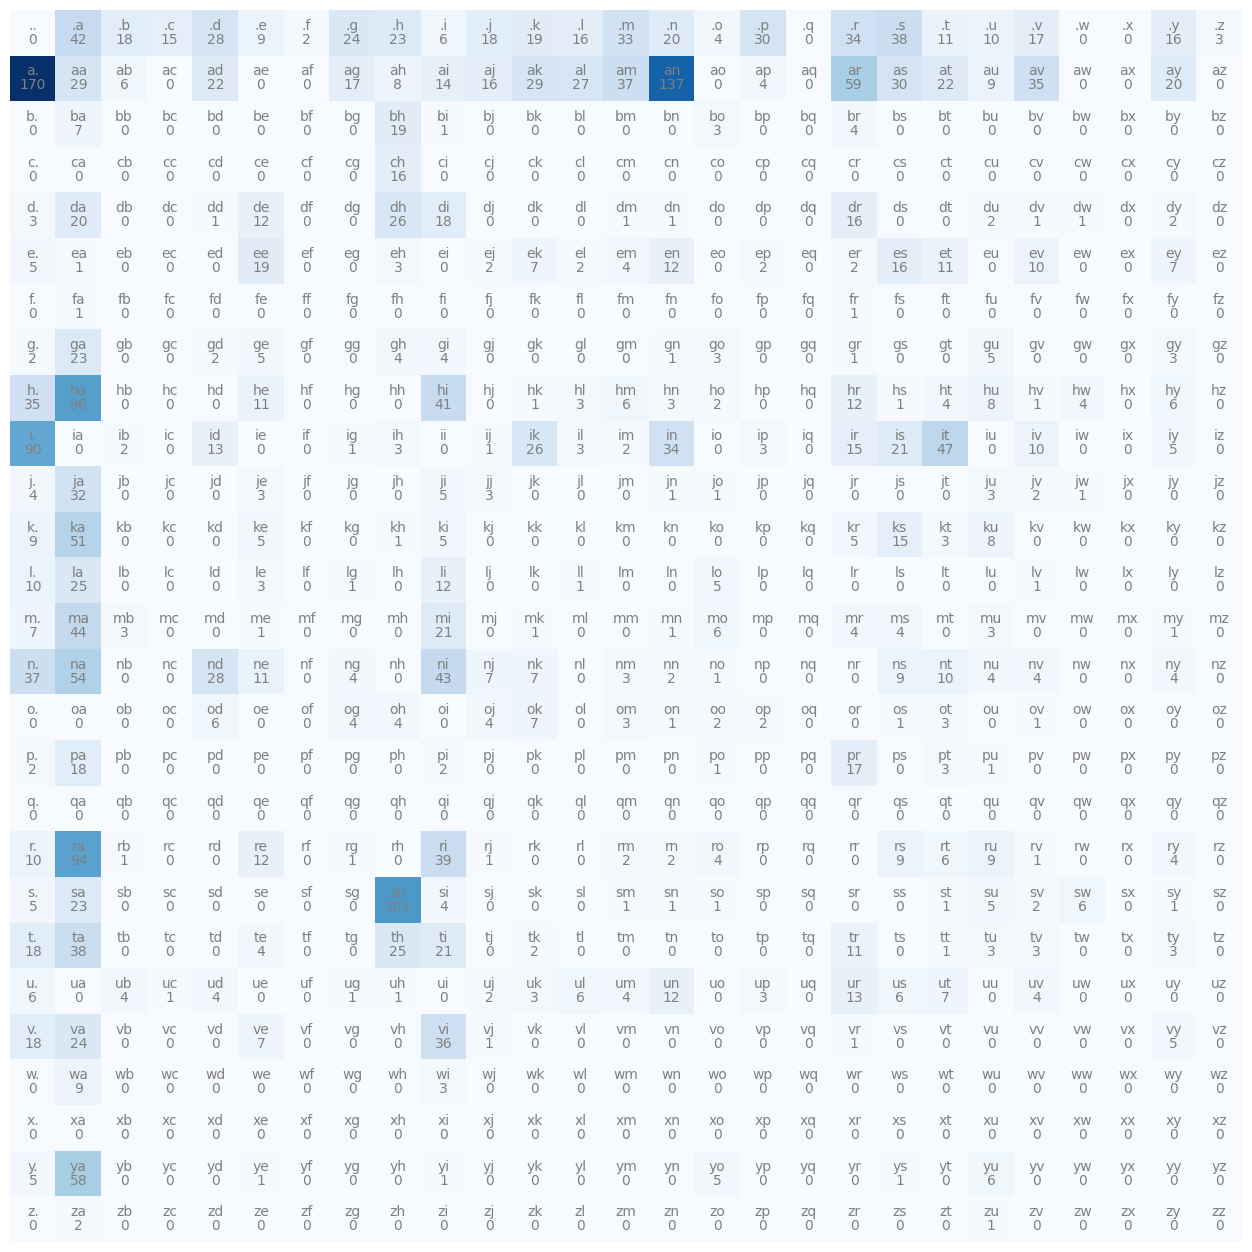

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
for i in range(27):
    for j in range(27):
        chstr = i2s[i] + i2s[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.imshow(N, cmap='Blues')
plt.axis('off')
plt.show()


In [11]:
# Convert N to float for division and add 1 for model smoothing
# Smoothing prevents zero probabilities, which would give us an infinite loss later
P = (N + 1).float()

# Sum each row and keep it as a column vector (27, 1)
# keepdim=True is VITAL for broadcasting to work correctly
row_sums = P.sum(dim=1, keepdim=True)

# Divide each row by its sum (broadcasting does the magic here)
P /= row_sums

# Let's check that the first row sums to 1
print(f"Sum of the first row: {P[0].sum()}")

Sum of the first row: 1.0


In [13]:
g = torch.Generator().manual_seed(2147483647) # For reproducibility

for i in range(20):
  out = []
  ix = 0 # Start with the '.' token
  while True:
    p = P[ix] # Get the probability distribution for the next character
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    if ix == 0: # If we sample the '.' token, we're done
      break
    out.append(i2s[ix])
  print(''.join(out))

junidha
prakadhu
cfayoodina
shiniti
shasaget
vi
hniduvinilevini
dbdainrwi
bh
shininayaarth
unvaumarafodtumj
pryashwahajani
coha
yari
cfka
janditejamiki
wyfin
anaasn
svi
hansuxhadgosfmitanai


In [14]:
log_likelihood = 0.0
n = 0

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = s2i[ch1]
    ix2 = s2i[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'Average NLL (Loss): {nll/n}')

log_likelihood=tensor(-7282.4951)
nll=tensor(7282.4951)
Average NLL (Loss): 2.2028114795684814


In [15]:
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = s2i[ch1]
    ix2 = s2i[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

number of examples:  3306


In [16]:
import torch.nn.functional as F

# Initialize the 'network' weights randomly
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [17]:
# Gradient descent loop
for k in range(100):
  # --- Forward pass ---
  # 1. One-hot encode our inputs
  # We can't multiply integers directly, so we use one-hot vectors
  x_one_hot = F.one_hot(xs, num_classes=27).float()

  # 2. Get the 'logits' by matrix multiplying with weights
  # (num_examples, 27) @ (27, 27) -> (num_examples, 27)
  logits = x_one_hot @ W

  # 3. Apply Softmax to get probabilities
  # Softmax is just exponentiation followed by normalization
  counts = logits.exp() # equivalent to N
  probs = counts / counts.sum(dim=1, keepdims=True) # probability distributions

  # 4. Calculate the loss (average NLL)
  loss = -probs[torch.arange(num), ys].log().mean()
  print(f"Epoch {k+1}, Loss: {loss.item()}")

  # --- Backward pass ---
  # Reset gradients to zero before calculating new ones
  W.grad = None
  loss.backward()

  # --- Update weights ---
  # Move weights in the opposite direction of the gradient
  learning_rate = 50
  W.data += -learning_rate * W.grad

Epoch 1, Loss: 3.783867359161377
Epoch 2, Loss: 3.179549217224121
Epoch 3, Loss: 2.9005117416381836
Epoch 4, Loss: 2.740831136703491
Epoch 5, Loss: 2.6374199390411377
Epoch 6, Loss: 2.563941478729248
Epoch 7, Loss: 2.508333206176758
Epoch 8, Loss: 2.467426061630249
Epoch 9, Loss: 2.4331037998199463
Epoch 10, Loss: 2.4100184440612793
Epoch 11, Loss: 2.384451150894165
Epoch 12, Loss: 2.37048077583313
Epoch 13, Loss: 2.348311185836792
Epoch 14, Loss: 2.339127540588379
Epoch 15, Loss: 2.3208673000335693
Epoch 16, Loss: 2.315244674682617
Epoch 17, Loss: 2.299884080886841
Epoch 18, Loss: 2.2966256141662598
Epoch 19, Loss: 2.2831063270568848
Epoch 20, Loss: 2.2814996242523193
Epoch 21, Loss: 2.269329071044922
Epoch 22, Loss: 2.268955945968628
Epoch 23, Loss: 2.2578015327453613
Epoch 24, Loss: 2.2583730220794678
Epoch 25, Loss: 2.2480013370513916
Epoch 26, Loss: 2.2493152618408203
Epoch 27, Loss: 2.23956298828125
Epoch 28, Loss: 2.241473913192749
Epoch 29, Loss: 2.2322213649749756
Epoch 30, Lo

In [18]:
import torch
import torch.nn.functional as F

# Generator for reproducibility
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    out = []
    ix = 0  # Start with '.' token
    while True:
        # One-hot encode current character index
        x_one_hot = F.one_hot(torch.tensor([ix]), num_classes=27).float()  # shape: (1, 27)

        # Get logits using learned weight matrix
        logits = x_one_hot @ W  # shape: (1, 27)

        # Convert logits to probabilities using softmax
        probs = logits.softmax(dim=1)  # shape: (1, 27)

        # Sample next character index from the probability distribution
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()

        if ix == 0:  # End of word
            break
        out.append(i2s[ix])  # Convert index to character and append
    print(''.join(out))


junidha
praka
ha
chayaa
na
guviniti
sha
aget
vi
hniduvinilevini
dbhainmwi
bh
shininayaa
th
unviumarafodhumi
pritshina
jani
chi
aya
hanaka
